In [1]:
from tensorflow import keras
from IPython.display import HTML
from base64 import b64encode
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

Train samples: 402
Test samples: 401


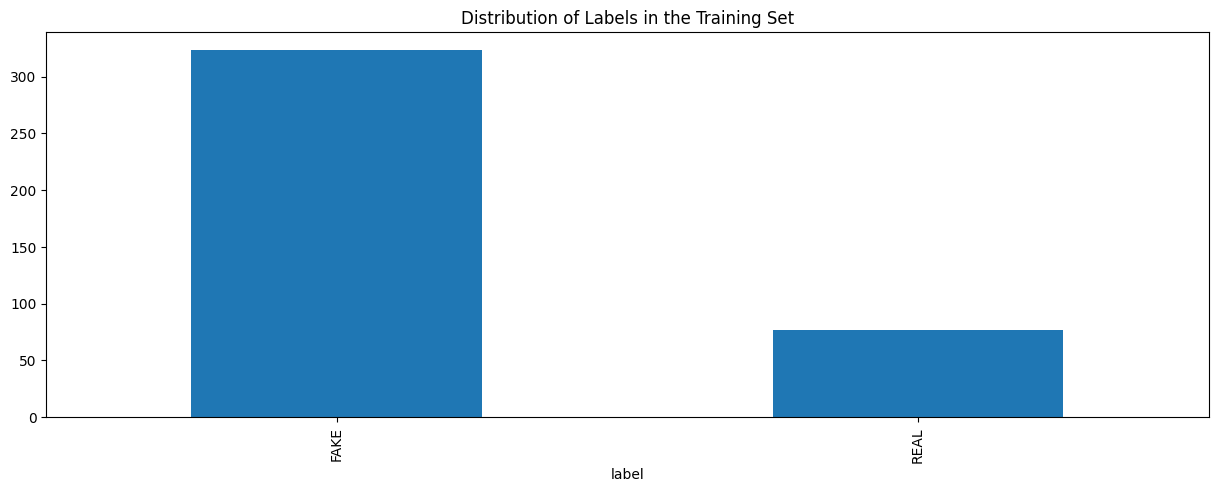

In [2]:
meta = pd.read_json(r'C:\Users\epava\ML\Project\train_sample_videos\metadata.json').T
DATA_FOLDER = 'C:/Users/epava/ML/Project/'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

meta.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

In [3]:
fake_train_sample_video = list(meta.loc[meta.label=='FAKE'].sample(3).index)
fake_train_sample_video

['ebywfrmhtd.mp4', 'byijojkdba.mp4', 'asmpfjfzif.mp4']

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [5]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=10, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [6]:
#InceptionV3 - object detection by google on the Imagenet dataset

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [7]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(int)

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    #print(f"FrameMask: {frame_masks}")
    #print(f"FrameFeature: {frame_features}")
    
    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [8]:
Train_set, Test_set = train_test_split(meta,test_size=0.1,random_state=42,stratify=meta['label'])

train_data, train_labels = prepare_all_videos(Train_set, os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER))

# print(f"Frame features in train set: {train_data[0].shape}")
# print(f"Frame masks in train set: {train_data[1].shape}")

1/1 [==============================] - 0s 24ms/step


In [9]:
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.GRU(16, return_sequences=True)(
    frame_features_input, mask=mask_input
)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([frame_features_input, mask_input], output)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 16)       99168       ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 8)            624         ['gru[0][0]']                

In [10]:
checkpoint = keras.callbacks.ModelCheckpoint('./', save_weights_only=True, save_best_only=True)
history = model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        callbacks=[checkpoint],
        epochs=EPOCHS,
        batch_size=8
    )

Epoch 1/10
45/45 [==============================] - 4s 10ms/step - loss: 0.5167 - accuracy: 0.8056
Epoch 2/10
45/45 [==============================] - 0s 8ms/step - loss: 0.5152 - accuracy: 0.8083
Epoch 3/10
45/45 [==============================] - 0s 8ms/step - loss: 0.4850 - accuracy: 0.8083
Epoch 4/10
45/45 [==============================] - 0s 8ms/step - loss: 0.5060 - accuracy: 0.8083
Epoch 5/10
45/45 [==============================] - 0s 8ms/step - loss: 0.4862 - accuracy: 0.8083
Epoch 6/10
45/45 [==============================] - 0s 9ms/step - loss: 0.4978 - accuracy: 0.8083
Epoch 7/10
45/45 [==============================] - 0s 8ms/step - loss: 0.4934 - accuracy: 0.8083
Epoch 8/10
45/45 [==============================] - 0s 8ms/step - loss: 0.4812 - accuracy: 0.8083
Epoch 9/10
45/45 [==============================] - 0s 7ms/step - loss: 0.4779 - accuracy: 0.8083
Epoch 10/10
45/45 [==============================] - 0s 7ms/step - loss: 0.4913 - accuracy: 0.8083


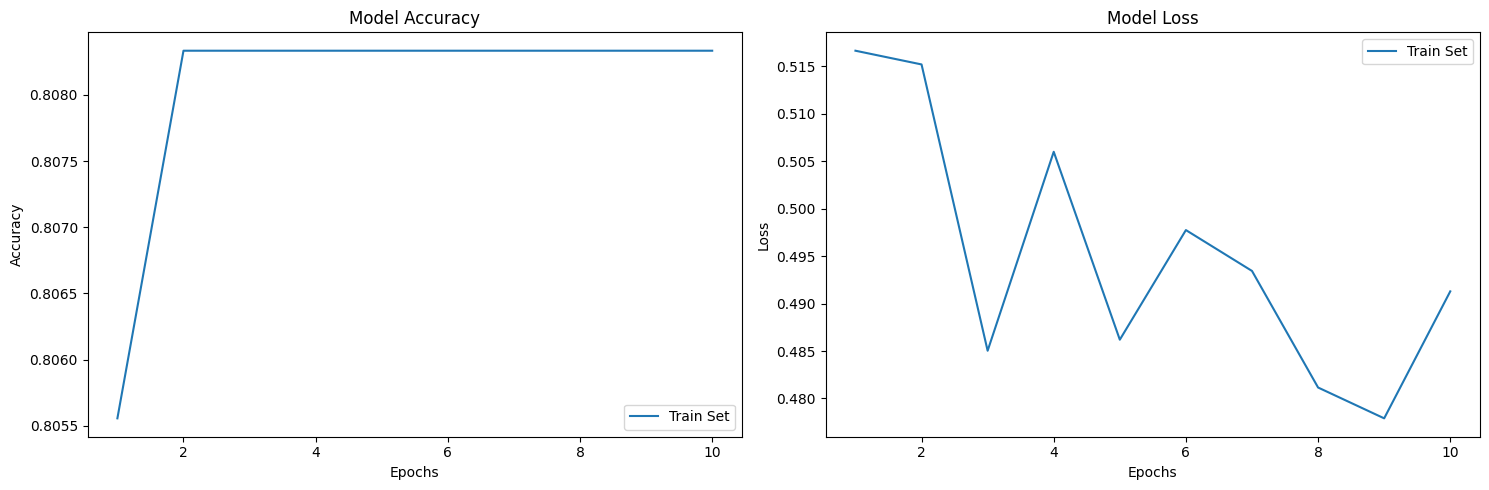

In [11]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [17]:
import statistics
print((history.history['loss']))
print((history.history['accuracy']))

[0.5166630744934082, 0.515216052532196, 0.4850292503833771, 0.5060061812400818, 0.48619353771209717, 0.4977511167526245, 0.49344316124916077, 0.48115116357803345, 0.47790098190307617, 0.4912891685962677]
[0.8055555820465088, 0.8083333373069763, 0.8083333373069763, 0.8083333373069763, 0.8083333373069763, 0.8083333373069763, 0.8083333373069763, 0.8083333373069763, 0.8083333373069763, 0.8083333373069763]


In [14]:
import random

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER,path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]
    

def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    video_url = open(os.path.join(DATA_FOLDER, subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)


ran = random.randint(0, Test_set.shape[0]-1)


video_file = Test_set.index[ran]
test_video = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file)
res = sequence_prediction(test_video)

print(f"Prediction score {res}")

if(res >= 0.5):
     print(f'The predicted class of the video is FAKE')
else:
     print(f'The predicted class of the video is REAL')

play_video(test_video)

1/1 [==============================] - 0s 20ms/step
Prediction score [0.8159258]
The predicted class of the video is FAKE
